In [4]:
import sys
sys.path.append('./')
import numpy as np
from timeseries import TimeSeriesRegressor

In [5]:
%matplotlib notebook
from skmultiflow.trees import RegressionHoeffdingTree, MultiTargetRegressionHoeffdingTree, HoeffdingTree
from skmultiflow.evaluation.evaluate_prequential import EvaluatePrequential
from skmultiflow.data.file_stream import FileStream
from skmultiflow.data import DataStream
import matplotlib as plt
import pandas as pd

plt.interactive(True)

dataset = "elec"

# 1. Create a stream

df = pd.read_csv("./data/"+dataset+".csv")
df.columns = [ str(i) for i in range(len(df.columns)) ]
df = pd.DataFrame({"t":df[df.columns[0]].astype(np.float32).tolist()[:-1],"t+1":df[df.columns[0]].tolist()[1:]})

stream = DataStream(df, n_targets=1, target_idx=-1)
# 2. Prepare for use
stream.prepare_for_use()


<IPython.core.display.Javascript object>


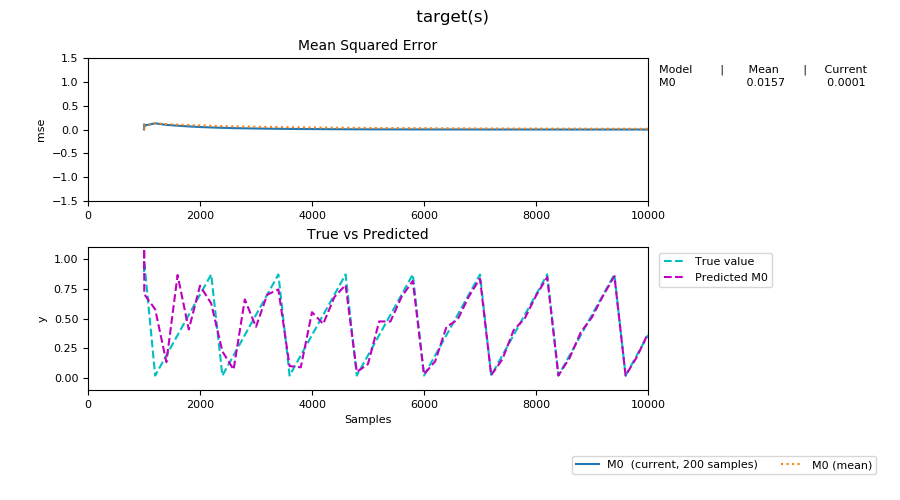

Prequential Evaluation
Evaluating 1 target(s).
Pre-training on 1000 sample(s).
Evaluating...
 #################### [100%] [53.62s]
Processed samples: 10000
Mean performance:
M0 - MSE          : 0.0157


[TimeSeriesRegressor(estimator=RegressionHoeffdingTree(binary_split=False,
                                                       grace_period=200,
                                                       leaf_prediction='perceptron',
                                                       learning_ratio_const=True,
                                                       learning_ratio_decay=0.001,
                                                       learning_ratio_perceptron=0.02,
                                                       max_byte_size=33554432,
                                                       memory_estimate_period=1000000,
                                                       nb_threshold=0,
                                                       no_preprune=False,
                                                       nominal_attributes=None,
                                                       random_state=None,
                                                  

In [6]:
h = RegressionHoeffdingTree()
model = TimeSeriesRegressor( h, max_window_size=100)

# 3. Setup the evaluator

evaluator = EvaluatePrequential(pretrain_size=1000, max_samples=10000, show_plot=True, 
                                metrics=['mean_square_error', 'true_vs_predicted' ], output_file='result_'+dataset+'.csv', 
                                batch_size=1)
# 4. Run
evaluator.evaluate(stream=stream, model=[model])

In [7]:
h = RegressionHoeffdingTree()
model = TimeSeriesRegressor( RegressionHoeffdingTree(), max_window_size=100)

stream.restart()
y = stream.next_sample(batch_size=150)
model.partial_fit(y[0], y[1])

TimeSeriesRegressor(estimator=RegressionHoeffdingTree(binary_split=False,
                                                      grace_period=200,
                                                      leaf_prediction='perceptron',
                                                      learning_ratio_const=True,
                                                      learning_ratio_decay=0.001,
                                                      learning_ratio_perceptron=0.02,
                                                      max_byte_size=33554432,
                                                      memory_estimate_period=1000000,
                                                      nb_threshold=0,
                                                      no_preprune=False,
                                                      nominal_attributes=None,
                                                      random_state=None,
                                                      remove_p

In [8]:
predictions = []
targets = []
for i in range(100):
    y = stream.next_sample(batch_size=10)
    model.partial_fit(y[0], y[1])
    
for i in range(5100):
    y = stream.next_sample(batch_size=1)
    
    predictions.append(model.forcast(y[0],n_steps=100))
    targets.append(y[1])
    
    model.partial_fit(y[0], y[1])

<IPython.core.display.Javascript object>


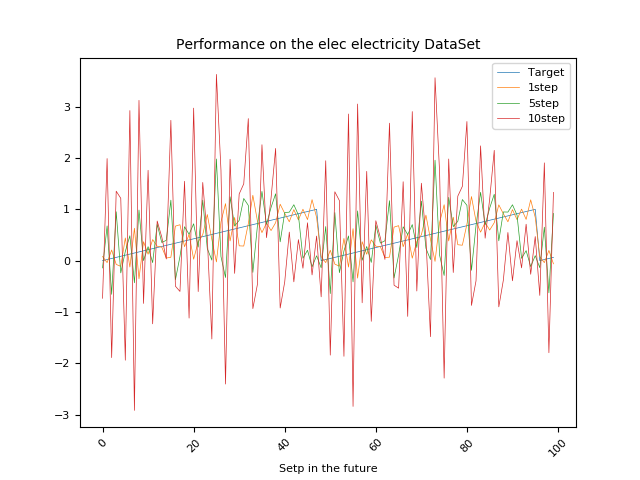

In [9]:
import pandas as pd
from matplotlib.pyplot import *

predictions = np.array(predictions)
targets = np.array(targets)
n = 100
df = pd.DataFrame({"id": range(n), "Target":targets[:n,0], "1step":predictions[:n,0], "5step":predictions[:n,4], "10step":predictions[:n,9], "20step":predictions[:n,19] })
ax = df.plot(x="id", y=["Target","1step","5step","10step"], rot=45, linewidth=.5)
ax.set_xlabel("Setp in the future")
ax.set_title("Performance on the %s electricity DataSet" % dataset)
ax.legend(["Target","1step","5step","10step"], loc='best')
show()